# Using LSTMs, CNNs, GRUs with a larger dataset


The General Language Understanding Evaluation (GLUE) benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems.

These resources include the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment. This colab uses version 2 of the SST dataset.

The splits are:

*   train	67,349
*   validation	872


and the column headings are:

*   sentence
*   label


For more information about the dataset, see [https://www.tensorflow.org/datasets/catalog/glue#gluesst2](https://www.tensorflow.org/datasets/catalog/glue#gluesst2)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Get the dataset


In [2]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.FLB177_2.0.0/glue-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/872 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.FLB177_2.0.0/glue-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.FLB177_2.0.0/glue-test.tfrecord*...:   0%|          |…

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [3]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [4]:
# Print some of the entries
for example in dataset_train.take(2):
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [5]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(-1):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  67349
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences


In [6]:
# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


# Pad the sequences

In [7]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),  # Additional dense layer
    tf.keras.layers.BatchNormalization(),  # Batch normalization for stability
    tf.keras.layers.Dropout(0.5),  # Another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [9]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6072 - loss: 0.6400 - val_accuracy: 0.7993 - val_loss: 0.4651
Epoch 2/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7830 - loss: 0.4493 - val_accuracy: 0.7523 - val_loss: 0.5736
Epoch 3/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8049 - loss: 0.4133 - val_accuracy: 0.7959 - val_loss: 0.4984
Epoch 4/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8137 - loss: 0.3948 - val_accuracy: 0.7718 - val_loss: 0.5473
Epoch 5/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8218 - loss: 0.3865 - val_accuracy: 0.7741 - val_loss: 0.5275
Epoch 6/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8260 - loss: 0.3734 - val_accuracy: 0.7844 - val_loss: 0.5266
Epoch 7/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8263 - loss: 0.3740 - val_accuracy: 0.7856 - val_loss: 0.5080
Epoch 8/20
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8299 - loss: 0.3667 -

# Plot the accurracy and loss

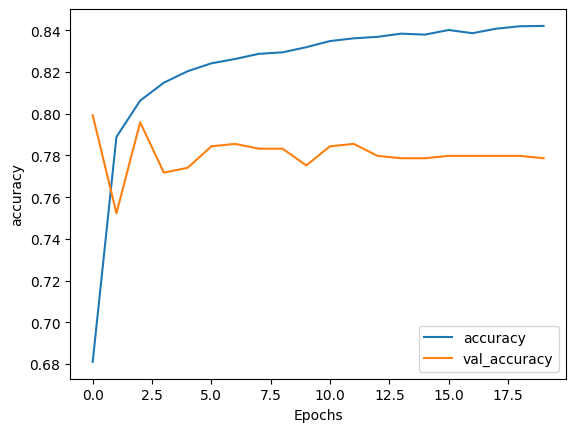

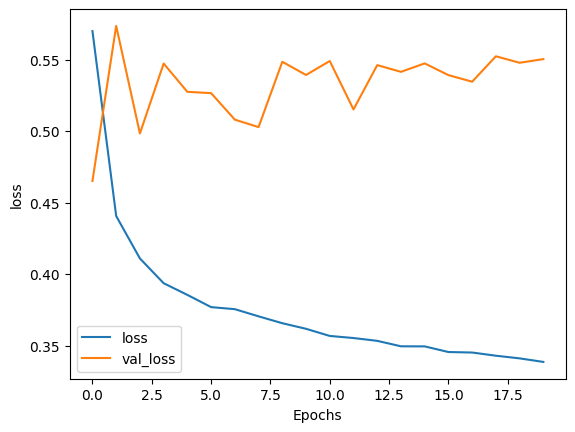

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [11]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [12]:


def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
I loved this movie
[0.9750199]


that was the worst movie I've ever seen
[0.0254244]


too much violence even for a Bond film
[0.05533957]


a captivating recounting of a cherished myth
[0.8871044]




# Define a function to train and show the results of models with different layers

In [13]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# Use a CNN

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5378 - loss: 0.7005 - val_accuracy: 0.5103 - val_loss: 0.6950
Epoch 2/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6053 - loss: 0.6554 - val_accuracy: 0.6812 - val_loss: 0.5900
Epoch 3/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7886 - loss: 0.4436 - val_accuracy: 0.7156 - val_loss: 0.5959
Epoch 4/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8326 - loss: 0.3596 - val_accuracy: 0.7076 - val_loss: 0.6277
Epoch 5/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8433 - loss: 0.3313 - val_accuracy: 0.6938 - val_loss: 0.6406
Epoch 6/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8567 - loss: 0.3074 - val_accuracy: 0.6858 - val_loss: 0.6759
Epoch 7/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8620 - loss: 0.2854 - val_accuracy: 0.6858 - val_loss: 0.6886
Epoch 8/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8712 - loss: 0.2721

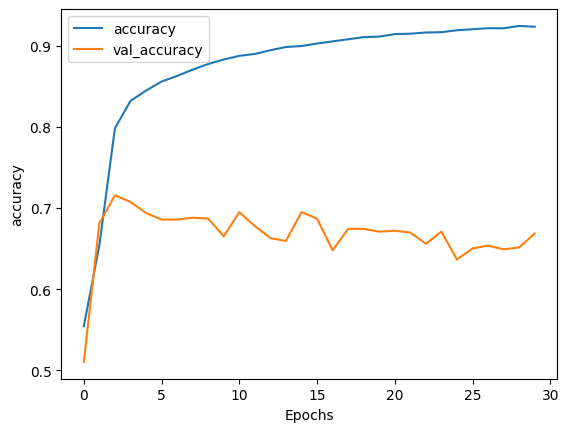

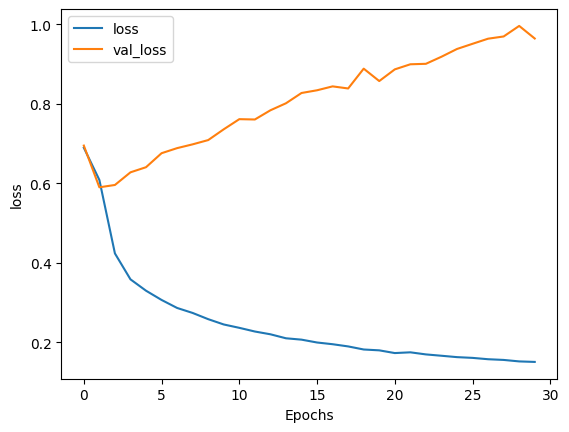

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
I loved this movie
[0.57152575]


that was the worst movie I've ever seen
[0.00721574]


too much violence even for a Bond film
[0.00408295]


a captivating recounting of a cherished myth
[0.5104924]




In [14]:
num_epochs = 30


model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),  # Increased filters
    tf.keras.layers.MaxPooling1D(pool_size=2),  # Added MaxPooling layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),  # Added another Conv1D layer
    tf.keras.layers.MaxPooling1D(pool_size=2),  # Another MaxPooling layer
    tf.keras.layers.GlobalMaxPooling1D(),  # Global Max Pooling to reduce dimensionality
    tf.keras.layers.Dropout(0.5),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),  # Additional dense layer
    tf.keras.layers.BatchNormalization(),  # Batch normalization for stability
    tf.keras.layers.Dropout(0.5),  # Another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5278 - loss: 0.6916 - val_accuracy: 0.5092 - val_loss: 0.8460
Epoch 2/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.6299 - loss: 0.6342 - val_accuracy: 0.5092 - val_loss: 1.0337
Epoch 3/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7627 - loss: 0.4858 - val_accuracy: 0.5115 - val_loss: 0.8368
Epoch 4/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.7998 - loss: 0.4190 - val_accuracy: 0.5138 - val_loss: 1.0520
Epoch 5/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8224 - loss: 0.3832 - val_accuracy: 0.5356 - val_loss: 0.8114
Epoch 6/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8321 - loss: 0.3645 - val_accuracy: 0.5608 - val_loss: 0.8025
Epoch 7/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.8356 - loss: 0.3521 - val_accuracy: 0.5826 - val_loss: 0.7874
Epoch 8/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.8407 -

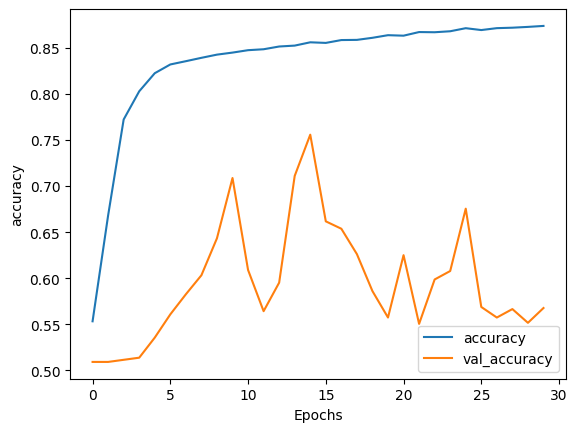

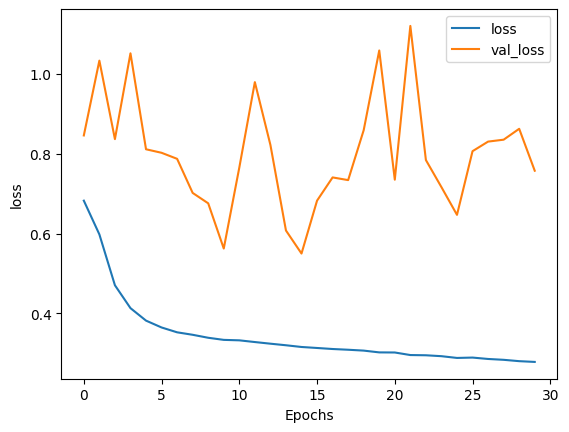

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
I loved this movie
[0.98924714]


that was the worst movie I've ever seen
[0.02812334]


too much violence even for a Bond film
[0.03880879]


a captivating recounting of a cherished myth
[0.97954386]




In [15]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),  # Increased GRU units and return sequences
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),  # Another GRU layer
    tf.keras.layers.Dropout(0.5),  # Dropout layer
    tf.keras.layers.Dense(64, activation='relu'),  # Additional dense layer
    tf.keras.layers.BatchNormalization(),  # Batch normalization for stability
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Add a bidirectional LSTM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.5503 - loss: 0.6846 - val_accuracy: 0.5092 - val_loss: 0.7674
Epoch 2/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7210 - loss: 0.5425 - val_accuracy: 0.5963 - val_loss: 0.6631
Epoch 3/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7889 - loss: 0.4390 - val_accuracy: 0.6984 - val_loss: 0.5527
Epoch 4/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.8135 - loss: 0.3937 - val_accuracy: 0.6548 - val_loss: 0.6168
Epoch 5/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.8247 - loss: 0.3685 - val_accuracy: 0.6686 - val_loss: 0.5952
Epoch 6/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8330 - loss: 0.3538 - val_accuracy: 0.6330 - val_loss: 0.6848
Epoch 7/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8354 - loss: 0.3477 - val_accuracy: 0.7477 - val_loss: 0.5313
Epoch 8/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.8400 -

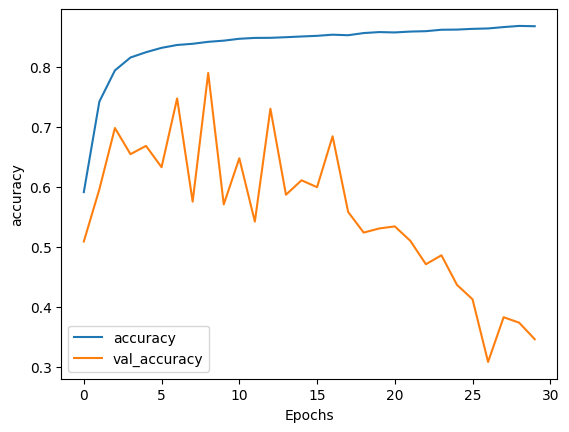

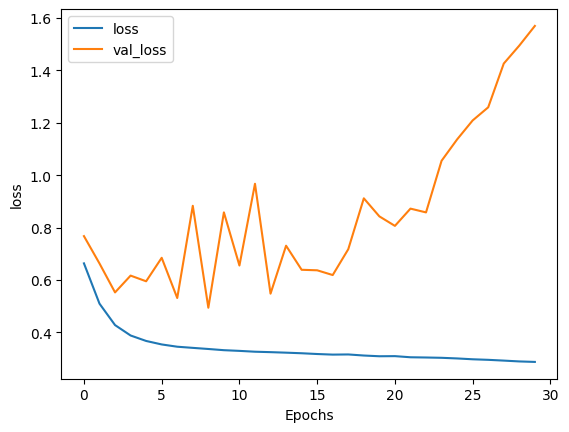

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
I loved this movie
[0.9876532]


that was the worst movie I've ever seen
[0.02877296]


too much violence even for a Bond film
[0.06520413]


a captivating recounting of a cherished myth
[0.93147904]




In [16]:
num_epochs = 30

# Build the upgraded Bidirectional LSTM model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  # Increased LSTM units
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),  # Additional dense layer
    tf.keras.layers.BatchNormalization(),  # Batch normalization for stability
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.6833 - loss: 0.5603 - val_accuracy: 0.5103 - val_loss: 1.3249
Epoch 2/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8288 - loss: 0.3660 - val_accuracy: 0.3578 - val_loss: 1.0270
Epoch 3/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.8459 - loss: 0.3331 - val_accuracy: 0.3773 - val_loss: 1.3041
Epoch 4/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8591 - loss: 0.3089 - val_accuracy: 0.4163 - val_loss: 1.1775
Epoch 5/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8618 - loss: 0.2953 - val_accuracy: 0.5183 - val_loss: 1.2882
Epoch 6/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8646 - loss: 0.2826 - val_accuracy: 0.4736 - val_loss: 1.2354
Epoch 7/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8698 - loss: 0.2691 - val_accuracy: 0.5115 - val_loss: 1.1529
Epoch 8/30
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8731 -

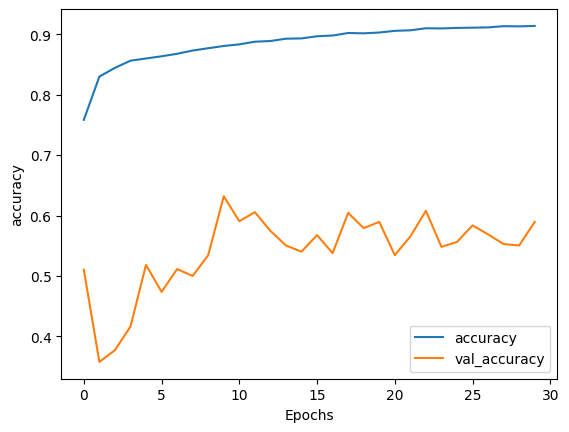

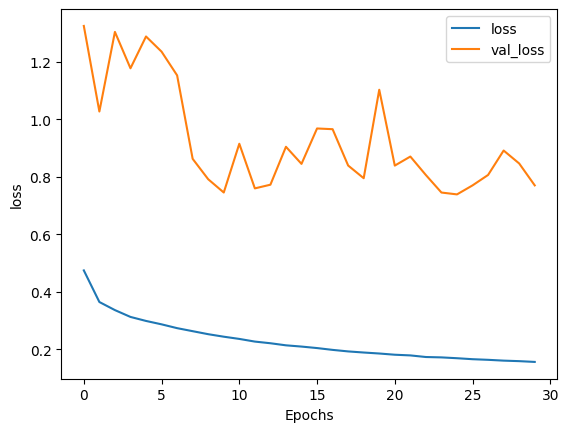

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
I loved this movie
[0.996142]


that was the worst movie I've ever seen
[0.09389016]


too much violence even for a Bond film
[0.05149709]


a captivating recounting of a cherished myth
[0.64631677]




In [18]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  # Increased LSTM units and return sequences
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  # Another Bidirectional LSTM layer
    tf.keras.layers.Dropout(0.5),  # Dropout layer
    tf.keras.layers.Dense(64, activation='relu'),  # Additional dense layer
    tf.keras.layers.BatchNormalization(),  # Batch normalization for stability
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [19]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
               review8, review9, review10]


In [20]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
I loved this movie
[0.9750199]


that was the worst movie I've ever seen
[0.0254244]


too much violence even for a Bond film
[0.05533957]


a captivating recounting of a cherished myth
[0.8871044]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.6984438]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5468831]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.41287994]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.03319684]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.00441

In [21]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
I loved this movie
[0.57152575]


that was the worst movie I've ever seen
[0.00721574]


too much violence even for a Bond film
[0.00408295]


a captivating recounting of a cherished myth
[0.5104924]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9996684]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.00281076]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.00320234]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.51313794]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 s

In [22]:
print("===========================\n","With multiple bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With multiple bidirectional GRU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
I loved this movie
[0.98924714]


that was the worst movie I've ever seen
[0.02812334]


too much violence even for a Bond film
[0.03880879]


a captivating recounting of a cherished myth
[0.97954386]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.99597776]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.98816675]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.13409787]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.13250552]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disapp

In [23]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
I loved this movie
[0.5018865]


that was the worst movie I've ever seen
[0.50208896]


too much violence even for a Bond film
[0.5013956]


a captivating recounting of a cherished myth
[0.5014439]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.5006686]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5008267]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.50183284]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5013091]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed 

In [24]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
I loved this movie
[0.996142]


that was the worst movie I've ever seen
[0.09389016]


too much violence even for a Bond film
[0.05149709]


a captivating recounting of a cherished myth
[0.64631677]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9883238]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.98504084]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.5647968]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9088685]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoin